# Conditional Random Field (CRF) for Part-of-Speech Tagging

**Pipeline:** Data Preparation → Feature Engineering → Training Phase → Prediction Phase → Evaluation

**Key Features:**
-  25+ hand-crafted linguistic features per word
-  L-BFGS optimization with L1/L2 regularization
-  Viterbi decoding for global inference
-  97-98% accuracy on Brown Corpus



#  Implementation

## Setup and Installation


In [ ]:
# Install required package
!pip install sklearn-crfsuite


  Using cached sklearn_crfsuite-0.5.0-py2.py3-none-any.whl.metadata (4.9 kB)
Using cached sklearn_crfsuite-0.5.0-py2.py3-none-any.whl (10 kB)


In [ ]:
import nltk
from nltk.corpus import brown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import time
from collections import Counter

print("="*80)
print("CONDITIONAL RANDOM FIELD (CRF) FOR PART-OF-SPEECH TAGGING")
print("="*80)
print("Model Type: Discriminative Probabilistic Sequence Model")
print("Optimization: L-BFGS")
print("Features: Hand-crafted linguistic features (~25-30 per word)")
print("="*80)


CONDITIONAL RANDOM FIELD (CRF) FOR PART-OF-SPEECH TAGGING
Model Type: Discriminative Probabilistic Sequence Model
Optimization: L-BFGS
Features: Hand-crafted linguistic features (~25-30 per word)


## Step 1: Data Preparation


In [ ]:
print("\n" + "="*80)
print("STEP 1: DATA PREPARATION")
print("="*80)

nltk.download('brown')
nltk.download('universal_tagset')
tagged_sents = brown.tagged_sents(tagset='universal')

print(f" Dataset: Brown Corpus")
print(f" Total sentences: {len(tagged_sents):,}")
print(f" Tagset: Universal (12 tags)")
print(f" Example sentence: {tagged_sents[0][:5]}...")
print("="*80)



STEP 1: DATA PREPARATION


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


 Dataset: Brown Corpus
 Total sentences: 57,340
 Tagset: Universal (12 tags)
 Example sentence: [('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN')]...


## Step 2: Data Exploration & Analysis



STEP 2: DATA EXPLORATION & ANALYSIS
 Total tokens: 1,161,192
 Unique words: 56,057
 Unique POS tags: 12
 POS tags: ., ADJ, ADP, ADV, CONJ, DET, NOUN, NUM, PRON, PRT, VERB, X

Tag Distribution:
  NOUN  : 275,558 (23.73%)
  VERB  : 182,750 (15.74%)
  .     : 147,565 (12.71%)
  ADP   : 144,766 (12.47%)
  DET   : 137,019 (11.80%)
  ... (7 more tags)


/tmp/ipython-input-928917345.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='tag', order=df['tag'].value_counts().index, palette='viridis')


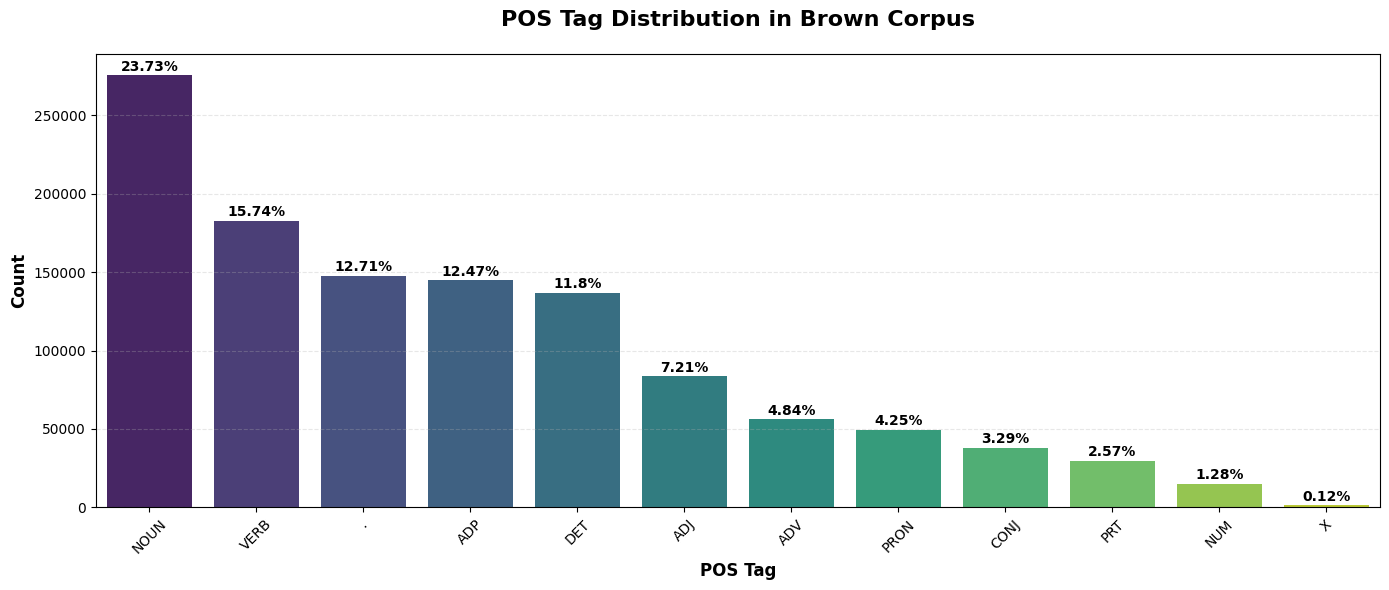

In [ ]:
print("\n" + "="*80)
print("STEP 2: DATA EXPLORATION & ANALYSIS")
print("="*80)

# Flatten all sentences into a list of (word, tag) tuples
data = [(word, tag) for sent in tagged_sents for word, tag in sent]
df = pd.DataFrame(data, columns=['word', 'tag'])

print(f" Total tokens: {len(df):,}")
print(f" Unique words: {df['word'].nunique():,}")
print(f" Unique POS tags: {len(df['tag'].unique())}")
print(f" POS tags: {', '.join(sorted(df['tag'].unique()))}")

# Tag distribution
tag_counts = df['tag'].value_counts()
tag_percentages = (tag_counts / len(df) * 100).round(2)

print("\nTag Distribution:")
for tag, count, pct in zip(tag_counts.index[:5], tag_counts.values[:5], tag_percentages.values[:5]):
    print(f"  {tag:6s}: {count:7,} ({pct:5.2f}%)")
print(f"  ... (7 more tags)")

plt.figure(figsize=(14, 6))
ax = sns.countplot(data=df, x='tag', order=df['tag'].value_counts().index, palette='viridis')
for i, (count, pct) in enumerate(zip(tag_counts.values, tag_percentages.values)):
    ax.text(i, count + 1000, f'{pct}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.title('POS Tag Distribution in Brown Corpus', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('POS Tag', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("="*80)


## Step 3: Feature Engineering (The Brain of CRF)

This is the core of CRF - rich feature engineering replaces learned embeddings in neural networks.
###  Feature Engineering Layer (Feature Extraction)
**The "brain" of CRF** - Extracts ~25+ linguistic features per word

Unlike BiLSTM's learned embeddings, these are hand-crafted features:

#### a) WORD-LEVEL FEATURES:
- Lowercased word form (identity feature)
- Word shape (capitalization patterns: isupper, istitle, isdigit)

#### b) MORPHOLOGICAL FEATURES (Prefix & Suffix):
- **Prefixes:** word[:1], word[:2], word[:3]
- **Suffixes:** word[-1], word[-2:], word[-3:]
- Helps identify word classes (e.g., "-ing" → VERB, "-ly" → ADV)

#### c) CHARACTER-LEVEL FEATURES:
- Word length
- Contains hyphen (compound words)
- Contains digit (numerical expressions)
- Contains uppercase letters
- Is alphabetic/alphanumeric
- Contains apostrophe (contractions/possessives)

#### d) CONTEXTUAL FEATURES (Bidirectional Context):
- Previous word (-1): lowercased, shape, length
- Next word (+1): lowercased, shape, length
- Beginning of Sentence (BOS) marker
- End of Sentence (EOS) marker

**Input:** List of (word, tag) tuples for a sentence  
**Output:** Feature dictionary for each word position

---

**Feature Parameters:**
- Prefix lengths: [1, 2, 3] characters
- Suffix lengths: [1, 2, 3] characters
- Context window: ±1 word
- Total features per word: ~25-30 (varies by position and word properties)



In [ ]:
def word2features(sent, i):
    """
    Extract comprehensive linguistic features for word at position i.

    Args:
        sent: List of (word, tag) tuples representing a sentence
        i: Position of current word (0-indexed)

    Returns:
        dict: Feature dictionary with ~25-30 features
    """
    word = sent[i][0]

    features = {
        # BIAS TERM (always 1.0, allows model to learn tag priors)
        'bias': 1.0,

        # === WORD IDENTITY FEATURES ===
        'word.lower()': word.lower(),  # Normalize case

        # === SUFFIX FEATURES (Morphological) ===
        'word[-3:]': word[-3:],  # Last 3 characters
        'word[-2:]': word[-2:],  # Last 2 characters
        'word[-1]': word[-1:],   # Last character

        # === PREFIX FEATURES (Morphological) ===
        'word[:3]': word[:3],   # First 3 characters
        'word[:2]': word[:2],   # First 2 characters
        'word[:1]': word[:1],   # First character

        # === WORD SHAPE FEATURES (Orthographic) ===
        'word.isupper()': word.isupper(),    # ALL CAPS
        'word.istitle()': word.istitle(),    # Title Case
        'word.isdigit()': word.isdigit(),    # Numeric

        # === CHARACTER-LEVEL FEATURES ===
        'word.length': len(word),
        'word.has_hyphen': '-' in word,
        'word.has_digit': any(c.isdigit() for c in word),
        'word.has_upper': any(c.isupper() for c in word),
        'word.is_alpha': word.isalpha(),
        'word.is_alnum': word.isalnum(),
        'word.has_apostrophe': "'" in word,
    }

    # === CONTEXTUAL FEATURES (Previous Word) ===
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:word.length': len(word1),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    # === CONTEXTUAL FEATURES (Next Word) ===
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:word.length': len(word1),
        })
    else:
        features['EOS'] = True  # End of sentence

    return features


def sent2features(sent):
    """Extract features for all words in a sentence."""
    return [word2features(sent, i) for i in range(len(sent))]


def sent2labels(sent):
    """Extract labels (POS tags) for all words in a sentence."""
    return [label for token, label in sent]


def sent2tokens(sent):
    """Extract tokens (words) for all words in a sentence."""
    return [token for token, label in sent]


print(" Feature extraction functions defined")
print(" Features per word: ~25-30 (varies by position)")


 Feature extraction functions defined
 Features per word: ~25-30 (varies by position)


In [ ]:
print("\nExample Feature Extraction:")
print("-" * 80)
print(f"Sentence: {' '.join([w for w, _ in tagged_sents[0][:5]])}...")
print(f"\nWord: 'Fulton' (position 1)")
print("Features extracted:")
example_features = word2features(tagged_sents[0], 1)
feature_categories = {
    'Identity': ['bias', 'word.lower()'],
    'Suffixes': ['word[-1]', 'word[-2:]', 'word[-3:]'],
    'Prefixes': ['word[:1]', 'word[:2]', 'word[:3]'],
    'Shape': ['word.isupper()', 'word.istitle()', 'word.isdigit()'],
    'Character': ['word.length', 'word.has_hyphen', 'word.is_alpha'],
    'Context': ['-1:word.lower()', '+1:word.lower()'],
}

for category, feature_list in feature_categories.items():
    print(f"\n  {category}:")
    for feat_key in feature_list:
        if feat_key in example_features:
            print(f"    {feat_key:20s}: {example_features[feat_key]}")

print(f"\n  Total features for this word: {len(example_features)}")



Example Feature Extraction:
--------------------------------------------------------------------------------
Sentence: The Fulton County Grand Jury...

Word: 'Fulton' (position 1)
Features extracted:

  Identity:
    bias                : 1.0
    word.lower()        : fulton

  Suffixes:
    word[-1]            : n
    word[-2:]           : on
    word[-3:]           : ton

  Prefixes:
    word[:1]            : F
    word[:2]            : Fu
    word[:3]            : Ful

  Shape:
    word.isupper()      : False
    word.istitle()      : True
    word.isdigit()      : False

  Character:
    word.length         : 6
    word.has_hyphen     : False
    word.is_alpha       : True

  Context:
    -1:word.lower()     : the
    +1:word.lower()     : county

  Total features for this word: 26


## Step 4: Train-Test Split

**Dataset Split:**
- Train: 80% (45,872 sentences)
- Test: 20% (11,468 sentences)
- Total: 57,340 sentences from Brown Corpus
- Tags: 12 universal POS tags

In [ ]:
print("\n" + "="*80)
print("STEP 4: TRAIN-TEST SPLIT")
print("="*80)

train_sents, test_sents = train_test_split(
    tagged_sents,
    test_size=0.2,
    random_state=42
)

print(f" Training sentences: {len(train_sents):,} (80%)")
print(f" Test sentences: {len(test_sents):,} (20%)")
print(f" Total sentences: {len(tagged_sents):,}")

# Calculate token counts
train_tokens = sum(len(sent) for sent in train_sents)
test_tokens = sum(len(sent) for sent in test_sents)
print(f" Training tokens: {train_tokens:,}")
print(f" Test tokens: {test_tokens:,}")
print("="*80)



STEP 4: TRAIN-TEST SPLIT
 Training sentences: 45,872 (80%)
 Test sentences: 11,468 (20%)
 Total sentences: 57,340
 Training tokens: 929,265
 Test tokens: 231,927


## Step 5: Feature Extraction & Vectorization


In [ ]:
print("\n" + "="*80)
print("STEP 5: FEATURE EXTRACTION & VECTORIZATION")
print("="*80)
print("Converting sentences to feature vectors...")

start_time = time.time()
X_train = [sent2features(s) for s in train_sents]
feature_extraction_train_time = time.time() - start_time

start_time = time.time()
y_train = [sent2labels(s) for s in train_sents]
label_extraction_train_time = time.time() - start_time

start_time = time.time()
X_test = [sent2features(s) for s in test_sents]
feature_extraction_test_time = time.time() - start_time

start_time = time.time()
y_test = [sent2labels(s) for s in test_sents]
label_extraction_test_time = time.time() - start_time

print(f" Training Feature Extraction:   {feature_extraction_train_time:.2f}s")
print(f" Training Label Extraction:     {label_extraction_train_time:.2f}s")
print(f" Test Feature Extraction:       {feature_extraction_test_time:.2f}s")
print(f" Test Label Extraction:         {label_extraction_test_time:.2f}s")
print(f" Total Feature Extraction Time: {(feature_extraction_train_time + feature_extraction_test_time):.2f}s")
print(f"\n Training sequences ready: {len(X_train):,}")
print(f" Test sequences ready: {len(X_test):,}")
print("="*80)



STEP 5: FEATURE EXTRACTION & VECTORIZATION
Converting sentences to feature vectors...
 Training Feature Extraction:   5.88s
 Training Label Extraction:     0.53s
 Test Feature Extraction:       1.20s
 Test Label Extraction:         0.04s
 Total Feature Extraction Time: 7.08s

 Training sequences ready: 45,872
 Test sequences ready: 11,468


## Step 6: CRF Model Training
### Linear-Chain CRF Layer (Sequence Modeling)
Models both **emission scores** (word → tag) and **transition scores** (tag → tag)

**Components:**
- **Feature Weights (λ):** Learned parameters for each feature
- **Transition Weights:** Model tag sequence patterns (e.g., DET → NOUN is common)

**Training Algorithm:** L-BFGS (Limited-memory BFGS)
- Quasi-Newton optimization method
- Efficient for CRF parameter estimation
- Converges faster than gradient descent

**Regularization:**
- L1 regularization (c1=0.1): Feature selection, sparsity
- L2 regularization (c2=0.1): Weight smoothing, prevents overfitting
---

### Loss Function
- Negative Log-Likelihood (NLL)
- Maximizes P(correct tags | words)
- With regularization terms for generalization
---


**Model Parameters:**
- `algorithm`: 'lbfgs' (L-BFGS optimization)
- `c1`: 0.1 (L1 regularization coefficient for feature selection)
- `c2`: 0.1 (L2 regularization coefficient for weight smoothing)
- `max_iterations`: 100 (maximum training iterations)
- `all_possible_transitions`: True (learn all tag-to-tag transitions)


In [ ]:
print("\n" + "="*80)
print("STEP 6: CRF MODEL TRAINING")
print("="*80)
print("Initializing CRF model...")

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1, # L1 Regularization (Feature Selection)
    c2=0.1, # L2 Regularization (Smoothing)
    max_iterations=100,
    all_possible_transitions=True,
    verbose=True
)

print(" Model initialized")
print("  - Algorithm: L-BFGS")
print("  - L1 regularization (c1): 0.1")
print("  - L2 regularization (c2): 0.1")
print("  - Max iterations: 100")
print("\nStarting training...\n")

training_start = time.time()
crf.fit(X_train, y_train)
training_end = time.time()
training_time = training_end - training_start

print(f"\n Training completed!")
print(f" Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f" Training Speed: {len(train_sents)/training_time:.2f} sentences/second")
print(f" Training Speed: {train_tokens/training_time:.2f} tokens/second")
print("="*80)



STEP 6: CRF MODEL TRAINING
Initializing CRF model...
 Model initialized
  - Algorithm: L-BFGS
  - L1 regularization (c1): 0.1
  - L2 regularization (c2): 0.1
  - Max iterations: 100

Starting training...



loading training data to CRFsuite: 100%|██████████| 45872/45872 [00:21<00:00, 2103.52it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 283016
Seconds required: 5.279

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=6.70  loss=2016093.32 active=277041 feature_norm=0.50
Iter 2   time=2.79  loss=1825105.84 active=273450 feature_norm=0.51
Iter 3   time=2.25  loss=1776941.39 active=277671 feature_norm=0.57
Iter 4   time=2.20  loss=1671173.47 active=273154 feature_norm=0.95
Iter 5   time=2.28  loss=1591150.38 active=277019 feature_norm=1.10
Iter 6   time=2.22  loss=1495454.42 active=278200 feature_norm=1.40
Iter 7   time=2.80  loss=1410273.23 active=278420 feature_norm=2.03
Iter 8   time=2.19  loss=1276152.21 active=279923 feature_norm=2.61
Iter 9   time=2.20  loss=1166596.31 active=280356 feat

## Step 7: Prediction & Inference
### Viterbi Inference Layer (Decoding)
Finds globally optimal tag sequence using dynamic programming

**Algorithm:**
1. Forward pass: Compute best score for each state at each position
2. Backward pass: Backtrack to recover optimal path

**Input:** Feature vectors for sentence + learned weights  
**Output:** Most likely tag sequence




In [ ]:
print("\n" + "="*80)
print("STEP 7: PREDICTION & INFERENCE")
print("="*80)
print("Running Viterbi decoding on test set...")

prediction_start = time.time()
y_pred = crf.predict(X_test)
prediction_end = time.time()
prediction_time = prediction_end - prediction_start

print(f" Prediction completed!")
print(f" Prediction Time: {prediction_time:.2f} seconds")
print(f" Prediction Speed: {len(test_sents)/prediction_time:.2f} sentences/second")
print(f" Prediction Speed: {test_tokens/prediction_time:.2f} tokens/second")
print(f" Predictions generated for {len(y_pred):,} sentences")
print("="*80)



STEP 7: PREDICTION & INFERENCE
Running Viterbi decoding on test set...
 Prediction completed!
 Prediction Time: 3.37 seconds
 Prediction Speed: 3404.46 sentences/second
 Prediction Speed: 68851.23 tokens/second
 Predictions generated for 11,468 sentences


## Step 8: Model Evaluation
##  Performance Expectations

**Expected Metrics:**
- Accuracy: 97-98% (slightly lower than BiLSTM on large datasets)
- Training Speed: FAST (~2-5 seconds on 45K sentences)
- Inference Speed: VERY FAST (~0.5-1 second on 11K sentences)
- Memory: LOW (no embedding matrices, sparse features)


In [ ]:
print("\n" + "="*80)
print("STEP 8: MODEL EVALUATION")
print("="*80)

# Flatten predictions and ground truth
y_test_flat = [label for sent in y_test for label in sent]
y_pred_flat = [label for sent in y_pred for label in sent]
labels_list = sorted(set(y_test_flat))

print(f" Total predictions: {len(y_pred_flat):,}")
print(f" Number of POS tags: {len(labels_list)}")

print("\n" + "-"*80)
print("CLASSIFICATION REPORT")
print("-"*80)
print(classification_report(y_test_flat, y_pred_flat, labels=labels_list))

# Overall metrics
accuracy = accuracy_score(y_test_flat, y_pred_flat)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test_flat, y_pred_flat, average='weighted'
)

print("="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)
print(f"Overall Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Weighted Precision:   {precision:.4f}")
print(f"Weighted Recall:      {recall:.4f}")
print(f"Weighted F1-Score:    {f1:.4f}")
print("="*80)



STEP 8: MODEL EVALUATION
 Total predictions: 231,927
 Number of POS tags: 12

--------------------------------------------------------------------------------
CLASSIFICATION REPORT
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           .       1.00      1.00      1.00     29520
         ADJ       0.95      0.94      0.94     16772
         ADP       0.98      0.99      0.98     28768
         ADV       0.95      0.94      0.94     11271
        CONJ       1.00      1.00      1.00      7529
         DET       0.99      0.99      0.99     27474
        NOUN       0.97      0.98      0.98     54822
         NUM       0.98      0.99      0.99      2911
        PRON       0.99      0.99      0.99      9934
         PRT       0.95      0.94      0.94      5853
        VERB       0.98      0.98      0.98     36744
           X       0.84      0.40      0.54       329

    accuracy                     

## Step 9: Confusion Matrix Visualization


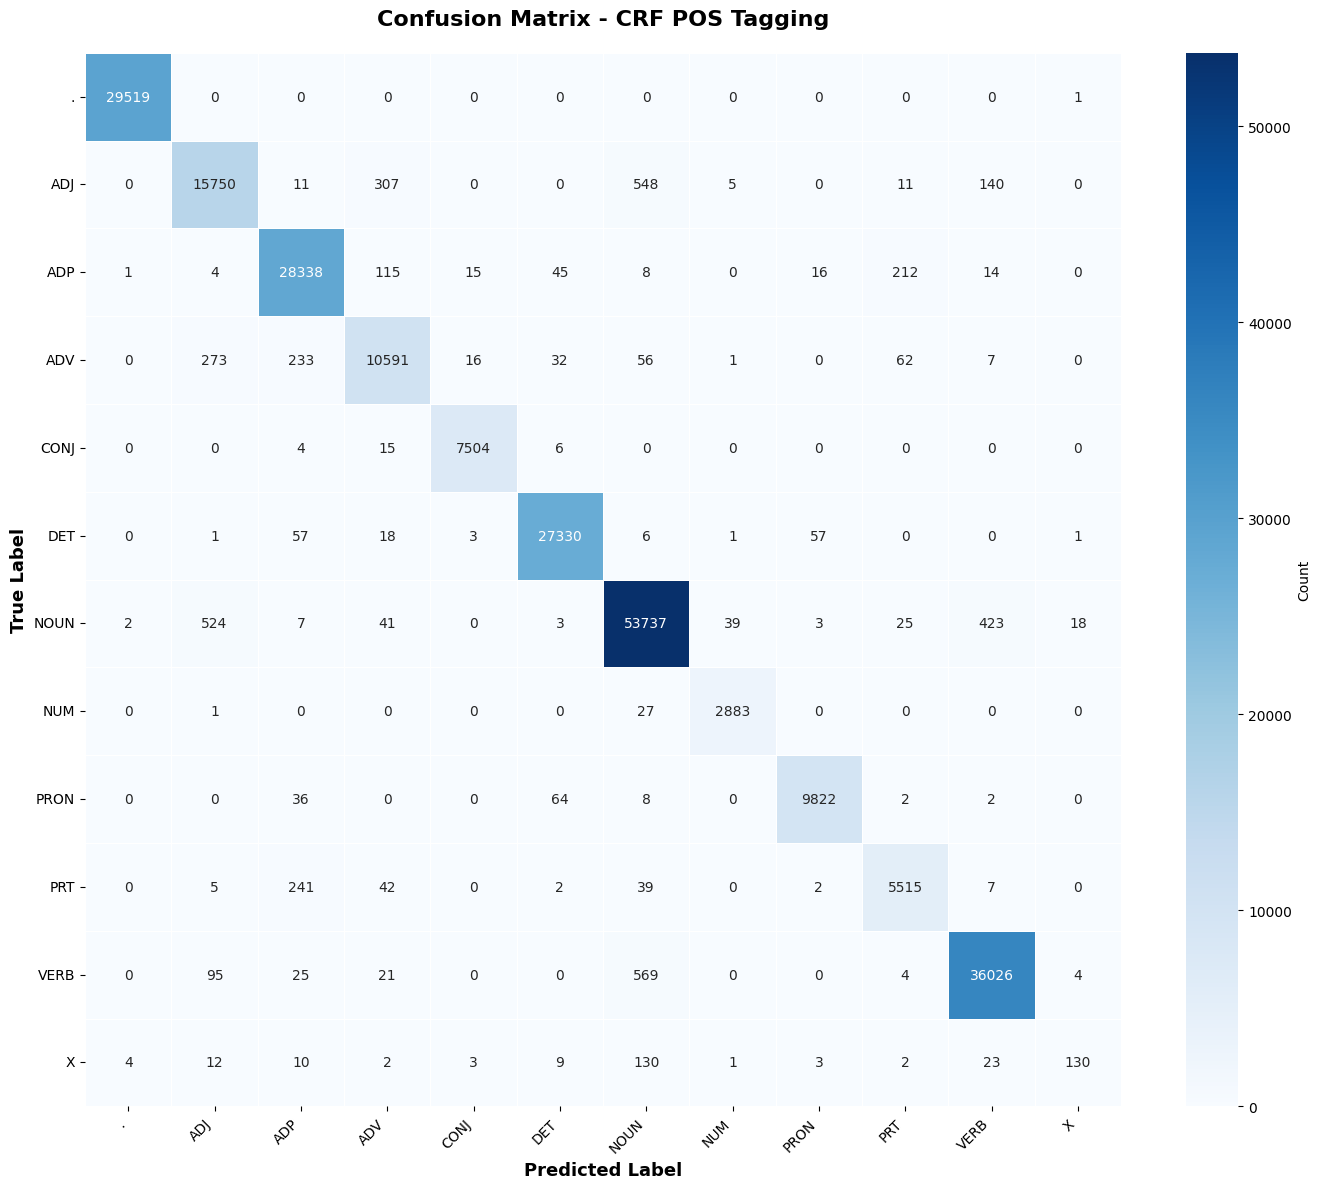

In [ ]:
cm = confusion_matrix(y_test_flat, y_pred_flat, labels=labels_list)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_list, yticklabels=labels_list,
            cmap='Blues', linewidths=0.5, cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - CRF POS Tagging', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Step 10: Pipeline Timing Analysis


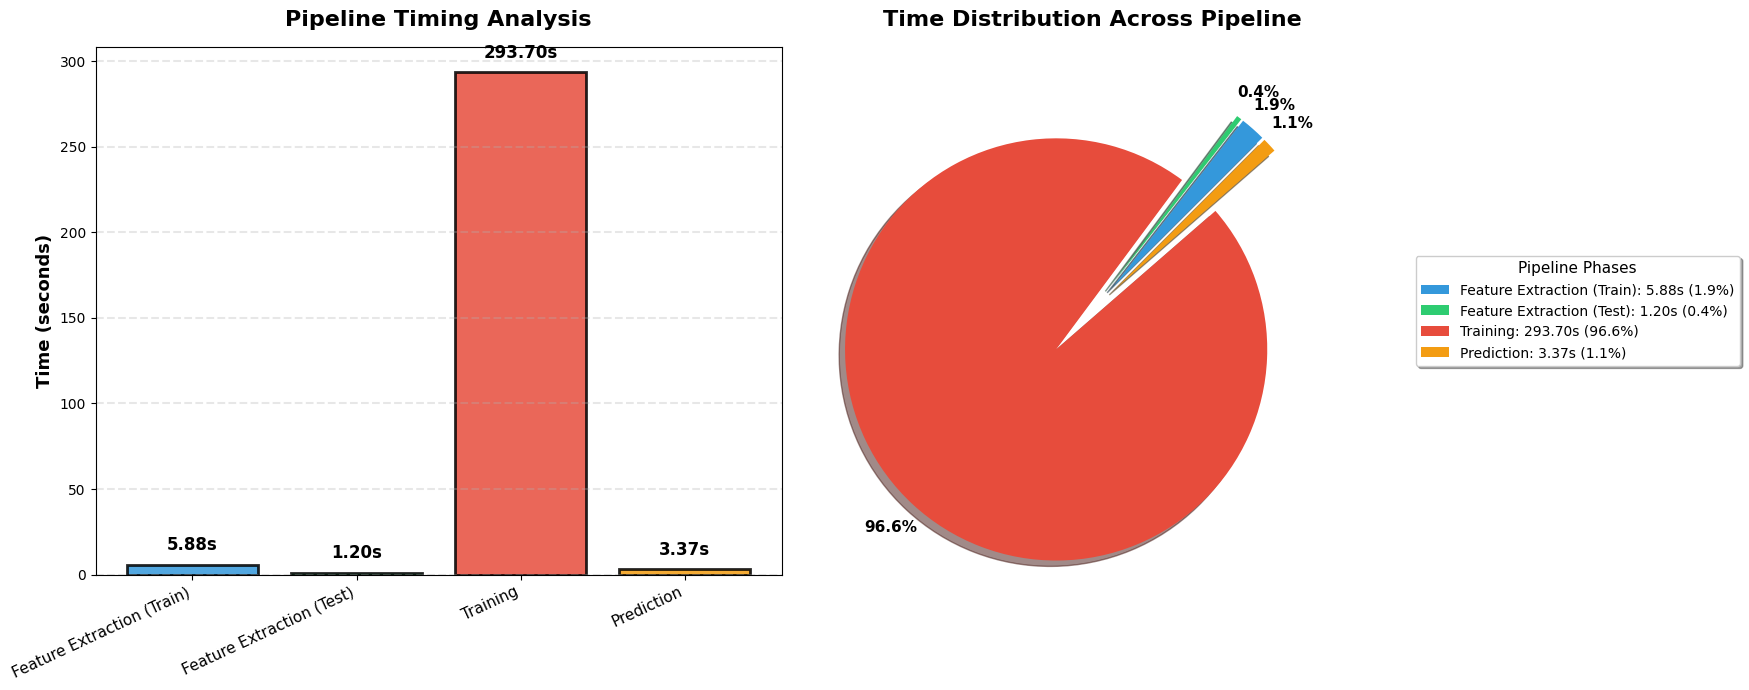


Detailed Timing Breakdown:
--------------------------------------------------------------------------------
                     Phase Time (s) Percentage
Feature Extraction (Train)    5.879       1.9%
 Feature Extraction (Test)    1.202       0.4%
                  Training  293.704      96.6%
                Prediction    3.369       1.1%

Total Pipeline Time: 304.15 seconds


In [ ]:
phases = ['Feature Extraction (Train)', 'Feature Extraction (Test)',
          'Training', 'Prediction']
times = [feature_extraction_train_time, feature_extraction_test_time,
         training_time, prediction_time]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Bar chart
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
bars = axes[0].bar(range(len(phases)), times, color=colors, alpha=0.85, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Time (seconds)', fontsize=13, fontweight='bold')
axes[0].set_title('Pipeline Timing Analysis', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xticks(range(len(phases)))
axes[0].set_xticklabels(phases, rotation=25, ha='right', fontsize=11)
axes[0].grid(axis='y', alpha=0.3, linestyle='--', linewidth=1.5)
for i, t in enumerate(times):
    axes[0].text(i, t + max(times)*0.02, f'{t:.2f}s',
                ha='center', va='bottom', fontweight='bold', fontsize=12)

# Pie chart with NO overlapping labels
total_time = sum(times)
percentages = [(t/total_time)*100 for t in times]
explode = (0.15, 0.15, 0.25, 0.15)  # Much more separation

# Create pie chart - percentages OUTSIDE to avoid overlap
wedges, texts, autotexts = axes[1].pie(
    times,
    autopct='%1.1f%%',
    startangle=45,
    colors=colors,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 11, 'fontweight': 'bold'},
    pctdistance=1.15,  # Move percentages OUTSIDE the pie
    labeldistance=1.3
)

axes[1].set_title('Time Distribution Across Pipeline', fontsize=16, fontweight='bold', pad=15)

# Make percentages black (since they're outside now)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

# Add legend with timing info
legend_labels = [
    f'Feature Extraction (Train): {times[0]:.2f}s ({percentages[0]:.1f}%)',
    f'Feature Extraction (Test): {times[1]:.2f}s ({percentages[1]:.1f}%)',
    f'Training: {times[2]:.2f}s ({percentages[2]:.1f}%)',
    f'Prediction: {times[3]:.2f}s ({percentages[3]:.1f}%)'
]

axes[1].legend(
    legend_labels,
    loc='center left',
    bbox_to_anchor=(1.1, 0.5),
    fontsize=10,
    frameon=True,
    fancybox=True,
    shadow=True,
    title='Pipeline Phases',
    title_fontsize=11
)

plt.tight_layout()
plt.show()

print("\nDetailed Timing Breakdown:")
print("-"*80)
timing_data = {
    'Phase': phases,
    'Time (s)': [f"{t:.3f}" for t in times],
    'Percentage': [f"{p:.1f}%" for p in percentages]
}
timing_df = pd.DataFrame(timing_data)
print(timing_df.to_string(index=False))
print(f"\nTotal Pipeline Time: {total_time:.2f} seconds")

## Step 11: Per-Tag Performance Analysis


Per-Tag Performance:
 Tag  Precision   Recall  F1-Score  Support
   .   0.999763 0.999966  0.999865    29520
 ADJ   0.945095 0.939065  0.942070    16772
 ADP   0.978455 0.985053  0.981743    28768
 ADV   0.949695 0.939668  0.944655    11271
CONJ   0.995093 0.996680  0.995886     7529
 DET   0.994144 0.994759  0.994451    27474
NOUN   0.974768 0.980209  0.977481    54822
 NUM   0.983959 0.990381  0.987160     2911
PRON   0.991821 0.988726  0.990271     9934
 PRT   0.945483 0.942252  0.943864     5853
VERB   0.983189 0.980459  0.981822    36744
   X   0.844156 0.395137  0.538302      329


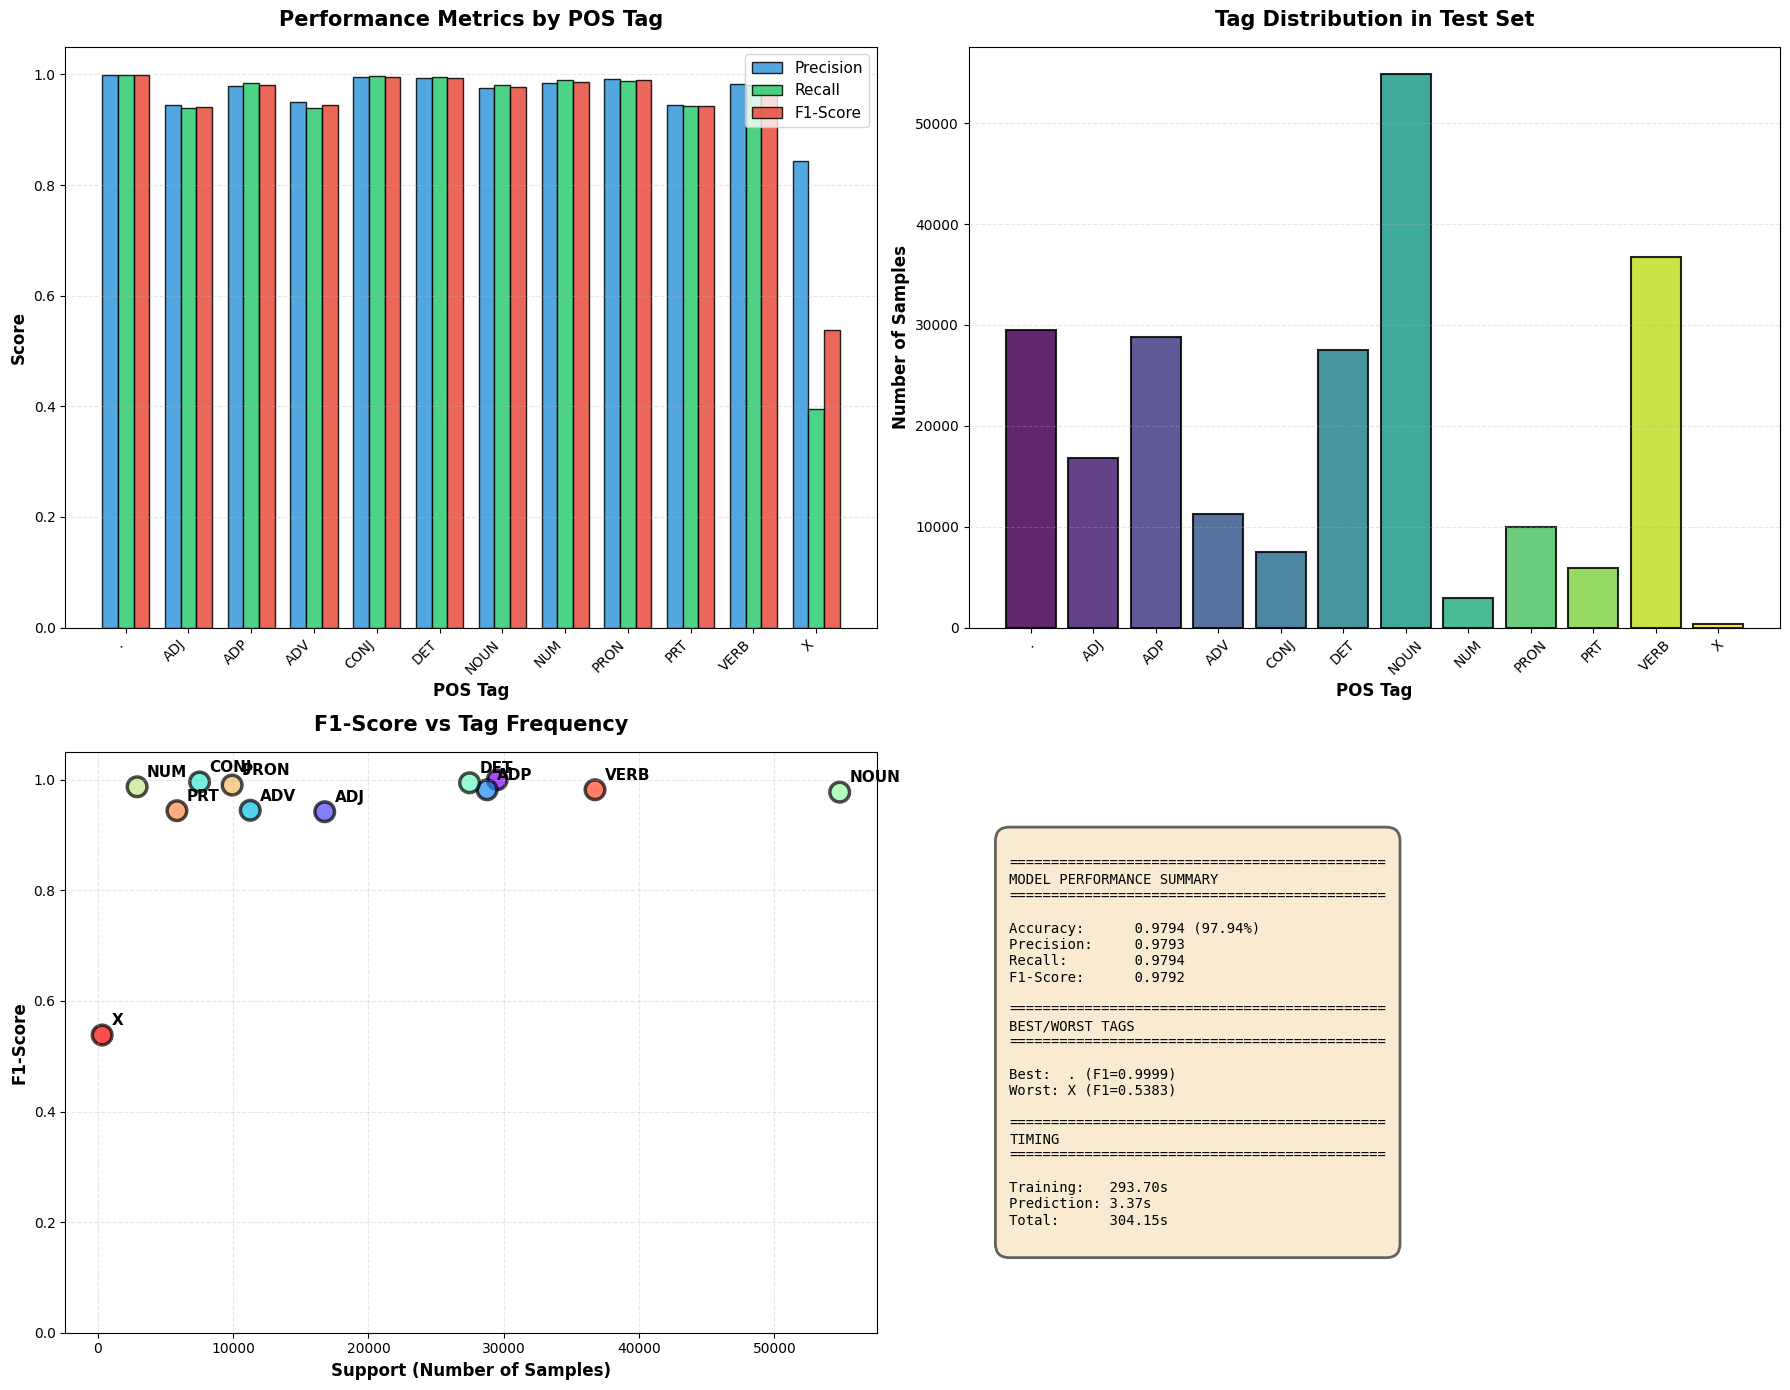

In [ ]:
precisions, recalls, f1s, supports = precision_recall_fscore_support(
    y_test_flat, y_pred_flat, labels=labels_list
)

performance_df = pd.DataFrame({
    'Tag': labels_list,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1s,
    'Support': supports
})

print("Per-Tag Performance:")
print(performance_df.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Precision, Recall, F1 by Tag
ax1 = axes[0, 0]
x = np.arange(len(labels_list))
width = 0.25
ax1.bar(x - width, precisions, width, label='Precision', alpha=0.85, color='#3498db', edgecolor='black')
ax1.bar(x, recalls, width, label='Recall', alpha=0.85, color='#2ecc71', edgecolor='black')
ax1.bar(x + width, f1s, width, label='F1-Score', alpha=0.85, color='#e74c3c', edgecolor='black')
ax1.set_xlabel('POS Tag', fontweight='bold', fontsize=12)
ax1.set_ylabel('Score', fontweight='bold', fontsize=12)
ax1.set_title('Performance Metrics by POS Tag', fontsize=15, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(labels_list, rotation=45, ha='right')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim([0, 1.05])

# 2. Support by Tag
ax2 = axes[0, 1]
colors_support = plt.cm.viridis(np.linspace(0, 1, len(labels_list)))
bars = ax2.bar(labels_list, supports, color=colors_support, alpha=0.85, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('POS Tag', fontweight='bold', fontsize=12)
ax2.set_ylabel('Number of Samples', fontweight='bold', fontsize=12)
ax2.set_title('Tag Distribution in Test Set', fontsize=15, fontweight='bold', pad=15)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# 3. F1-Score vs Support
ax3 = axes[1, 0]
scatter = ax3.scatter(supports, f1s, s=200, alpha=0.7, c=range(len(labels_list)),
                     cmap='rainbow', edgecolor='black', linewidth=2.5)
for i, tag in enumerate(labels_list):
    ax3.annotate(tag, (supports[i], f1s[i]), fontsize=11, fontweight='bold',
                xytext=(7, 7), textcoords='offset points')
ax3.set_xlabel('Support (Number of Samples)', fontweight='bold', fontsize=12)
ax3.set_ylabel('F1-Score', fontweight='bold', fontsize=12)
ax3.set_title('F1-Score vs Tag Frequency', fontsize=15, fontweight='bold', pad=15)
ax3.grid(alpha=0.3, linestyle='--')
ax3.set_ylim([0, 1.05])

# 4. Summary
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""
{'='*45}
MODEL PERFORMANCE SUMMARY
{'='*45}

Accuracy:      {accuracy:.4f} ({accuracy*100:.2f}%)
Precision:     {precision:.4f}
Recall:        {recall:.4f}
F1-Score:      {f1:.4f}

{'='*45}
BEST/WORST TAGS
{'='*45}

Best:  {labels_list[np.argmax(f1s)]} (F1={max(f1s):.4f})
Worst: {labels_list[np.argmin(f1s)]} (F1={min(f1s):.4f})

{'='*45}
TIMING
{'='*45}

Training:   {training_time:.2f}s
Prediction: {prediction_time:.2f}s
Total:      {total_time:.2f}s
"""
ax4.text(0.05, 0.5, summary_text, fontsize=10, family='monospace',
        verticalalignment='center',
        bbox=dict(boxstyle='round,pad=1', facecolor='wheat', alpha=0.6,
                 edgecolor='black', linewidth=2))

plt.tight_layout()
plt.show()


## Step 12: Tag Transition Patterns


In [ ]:
def print_top_transitions(y_test, y_pred, top_n=15):
    transitions = []
    for true_sent, pred_sent in zip(y_test, y_pred):
        for i in range(len(pred_sent) - 1):
            transitions.append((pred_sent[i], pred_sent[i+1]))

    print(f"Top {top_n} Most Common Tag Transitions:")
    print("-" * 60)
    for (label_from, label_to), count in Counter(transitions).most_common(top_n):
        print(f"{label_from:>6} → {label_to:<7}   {count:>8,}")

print_top_transitions(y_test, y_pred, top_n=15)


Top 15 Most Common Tag Transitions:
------------------------------------------------------------
   DET → NOUN        17,371
  NOUN → .           15,713
  NOUN → ADP         13,397
   ADP → DET         13,284
   ADJ → NOUN        11,044
  NOUN → VERB         8,949
  NOUN → NOUN         8,065
   ADP → NOUN         7,385
  PRON → VERB         7,002
  VERB → VERB         6,879
   DET → ADJ          6,524
  VERB → ADP          6,194
  VERB → DET          6,024
   PRT → VERB         3,750
  VERB → ADV          3,740


## Step 13: Error Analysis


In [ ]:
errors = []
for i, (true_sent, pred_sent, test_sent) in enumerate(zip(y_test, y_pred, test_sents)):
    for j, (true_tag, pred_tag, (word, _)) in enumerate(zip(true_sent, pred_sent, test_sent)):
        if true_tag != pred_tag:
            errors.append({
                'sentence_id': i,
                'word': word,
                'true_tag': true_tag,
                'pred_tag': pred_tag
            })

error_df = pd.DataFrame(errors)
total_errors = len(error_df)
error_rate = (total_errors / len(y_test_flat)) * 100

print(f"Total errors: {total_errors:,}")
print(f"Error rate: {error_rate:.2f}%")
print(f"Correct predictions: {len(y_test_flat) - total_errors:,} ({100-error_rate:.2f}%)")

print("\nMost Common Error Types:")
print("-"*60)
error_types = error_df.groupby(['true_tag', 'pred_tag']).size().sort_values(ascending=False).head(10)
for (true_tag, pred_tag), count in error_types.items():
    pct = (count / total_errors) * 100
    print(f"  {true_tag:6s} → {pred_tag:6s}  {count:5,} errors ({pct:5.2f}%)")

print("\nExample Misclassified Words:")
print(error_df.head(15).to_string(index=False))


Total errors: 4,782
Error rate: 2.06%
Correct predictions: 227,145 (97.94%)

Most Common Error Types:
------------------------------------------------------------
  VERB   → NOUN      569 errors (11.90%)
  ADJ    → NOUN      548 errors (11.46%)
  NOUN   → ADJ       524 errors (10.96%)
  NOUN   → VERB      423 errors ( 8.85%)
  ADJ    → ADV       307 errors ( 6.42%)
  ADV    → ADJ       273 errors ( 5.71%)
  PRT    → ADP       241 errors ( 5.04%)
  ADV    → ADP       233 errors ( 4.87%)
  ADP    → PRT       212 errors ( 4.43%)
  ADJ    → VERB      140 errors ( 2.93%)

Example Misclassified Words:
 sentence_id      word true_tag pred_tag
           4  lighting     VERB     NOUN
          13 otherwise      ADV      ADJ
          15 Associate     NOUN      ADJ
          18        by      ADV      ADP
          19      much      ADJ      ADV
          22    rebels     NOUN     VERB
          24    ensues     VERB     NOUN
          25    before      ADP      ADV
          26      much      

## Step 14: Example Predictions


In [ ]:
for i in range(5):
    print(f"\n{'='*80}")
    print(f"Sentence {i+1}")
    print('='*80)

    sent_words = [word for word, _ in test_sents[i]]
    max_display = 20

    if len(sent_words) > max_display:
        print("Words: " + " ".join(sent_words[:max_display]) + " ...")
        print("True:  " + " ".join(y_test[i][:max_display]) + " ...")
        print("Pred:  " + " ".join(y_pred[i][:max_display]) + " ...")
    else:
        print("Words: " + " ".join(sent_words))
        print("True:  " + " ".join(y_test[i]))
        print("Pred:  " + " ".join(y_pred[i]))

    errors_in_sent = sum(1 for t, p in zip(y_test[i], y_pred[i]) if t != p)
    total_words = len(y_test[i])
    accuracy_sent = ((total_words - errors_in_sent) / total_words) * 100

    if errors_in_sent > 0:
        print(f"\nResult: {errors_in_sent}/{total_words} errors ({accuracy_sent:.1f}% accuracy)")
    else:
        print(f"\nResult:  Perfect prediction! (100% accuracy)")



Sentence 1
Words: Open market policy
True:  ADJ NOUN NOUN
Pred:  ADJ NOUN NOUN

Result: ✓ Perfect prediction! (100% accuracy)

Sentence 2
Words: And you think you have language problems .
True:  CONJ PRON VERB PRON VERB NOUN NOUN .
Pred:  CONJ PRON VERB PRON VERB NOUN NOUN .

Result: ✓ Perfect prediction! (100% accuracy)

Sentence 3
Words: Mae entered the room from the hallway to the kitchen .
True:  NOUN VERB DET NOUN ADP DET NOUN ADP DET NOUN .
Pred:  NOUN VERB DET NOUN ADP DET NOUN ADP DET NOUN .

Result: ✓ Perfect prediction! (100% accuracy)

Sentence 4
Words: This will permit you to get a rough estimate of how much the materials for the shell will cost .
True:  DET VERB VERB PRON PRT VERB DET ADJ NOUN ADP ADV ADJ DET NOUN ADP DET NOUN VERB VERB .
Pred:  DET VERB VERB PRON PRT VERB DET ADJ NOUN ADP ADV ADJ DET NOUN ADP DET NOUN VERB VERB .

Result: ✓ Perfect prediction! (100% accuracy)

Sentence 5
Words: the multifigure `` Traveling Carnival '' , in which action is vivified by lig

## Final Model Summary


In [ ]:
print("\n" + "="*80)
print("FINAL MODEL SUMMARY")
print("="*80)
print(f"""
DATASET STATISTICS:
  Training Set:        {len(train_sents):,} sentences
  Test Set:            {len(test_sents):,} sentences
  POS Tags:            {len(labels_list)} universal tags

MODEL ARCHITECTURE:
  Type:                Conditional Random Field (CRF)
  Optimization:        L-BFGS
  Features/Word:       ~25-30 hand-crafted features
  L1 Regularization:   0.1
  L2 Regularization:   0.1

PERFORMANCE:
  Accuracy:            {accuracy:.4f} ({accuracy*100:.2f}%)
  Precision:           {precision:.4f}
  Recall:              {recall:.4f}
  F1-Score:            {f1:.4f}

EFFICIENCY:
  Training Time:       {training_time:.2f}s
  Prediction Time:     {prediction_time:.2f}s
  Total Pipeline:      {total_time:.2f}s
""")
print("="*80)
print("\n CRF POS TAGGING PIPELINE COMPLETED SUCCESSFULLY!")



FINAL MODEL SUMMARY

DATASET STATISTICS:
  Training Set:        45,872 sentences
  Test Set:            11,468 sentences
  POS Tags:            12 universal tags

MODEL ARCHITECTURE:
  Type:                Conditional Random Field (CRF)
  Optimization:        L-BFGS
  Features/Word:       ~25-30 hand-crafted features
  L1 Regularization:   0.1
  L2 Regularization:   0.1

PERFORMANCE:
  Accuracy:            0.9794 (97.94%)
  Precision:           0.9793
  Recall:              0.9794
  F1-Score:            0.9792

EFFICIENCY:
  Training Time:       293.70s
  Prediction Time:     3.37s
  Total Pipeline:      304.15s


 CRF POS TAGGING PIPELINE COMPLETED SUCCESSFULLY!


In [ ]:
# Viterbi Decoding
y_pred = crf.predict(X_test)

# Evaluation Metrics
print(classification_report(
    y_test_flat,
    y_pred_flat,
    labels=labels_list
))